# Case Study 3: Computational Methods in Finance

# Charles Laferte - cl4249

In [1]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm

## Import data

In [2]:
'''Standard & Poors 500 Index,Last: 4104.8301,Change:  -4.1099
Date: 12 avril 2023 √† 15:44 UTC‚àí4,Bid: 4104.1299,Ask: 4105.5498,Size: 1*1,Volume: 0'''

'Standard & Poors 500 Index,Last: 4104.8301,Change:  -4.1099\nDate: 12 avril 2023 √† 15:44 UTC‚àí4,Bid: 4104.1299,Ask: 4105.5498,Size: 1*1,Volume: 0'

Start_date

In [3]:
# Set the start date to compute the maturities
date_str = "2023-04-12"
# create a datetime object from the date string
start_date = datetime.strptime(date_str, "%Y-%m-%d")

Spot Price

In [4]:
S0 = 4104.8301

Rates

In [5]:
r = 0.0485

In [6]:
q = 0.0331026

Import market data

In [7]:
df_price = pd.read_csv("spx_4.csv", index_col=0)


In [8]:
#Filtrer les SPX... qui ne sont pas des SPXW...
mask = df_price['Calls'].str.contains('SPXW', case=False, na=False)
df_price = df_price[mask]

In [9]:
df_price.columns

Index(['Calls', 'Last Sale', 'Net', 'Bid', 'Ask', 'Volume', 'IV', 'Delta',
       'Gamma', 'Open Interest', 'Strike', 'Puts', 'Last Sale.1', 'Net.1',
       'Bid.1', 'Ask.1', 'Volume.1', 'IV.1', 'Delta.1', 'Gamma.1',
       'Open Interest.1'],
      dtype='object')

In [10]:
df_price[['Strike']]

,Strike
Expiration Date,
Wed Apr 12 2023,3450
Wed Apr 12 2023,3600
Wed Apr 12 2023,3625
Wed Apr 12 2023,3650
Wed Apr 12 2023,3675
...,...
Fri Jun 30 2023,4700
Fri Jun 30 2023,4750
Fri Jun 30 2023,4800


In [11]:
callPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
callPrices['Price'] = np.abs(df_price['Bid'].array + df_price['Ask'].array)/2
# Convert index to datetime
callPrices.index = pd.to_datetime(callPrices.index)

# Getting the weights inversely proportional to bid-ask spread
callPrices['w'] = np.abs(1/(df_price['Bid'].array - df_price['Ask'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
callPrices['Maturity'] = callPrices.index.to_series().apply(date_diff)
callPrices['Maturity'] = callPrices['Maturity']/252# trading days.../365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

callPrices = callPrices[callPrices['Strike']>=S0]

# drop today
callPrices = callPrices[callPrices['Maturity']!=0]
#579 avec zero mat included

In [12]:
putPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
putPrices['Price'] = np.abs(df_price['Bid.1'].array + df_price['Ask.1'].array)/2
# Convert index to datetime
putPrices.index = pd.to_datetime(putPrices.index)

# Getting the weights inversely proportional to bid-ask spread
putPrices['w'] = np.abs(1/(df_price['Bid.1'].array - df_price['Ask.1'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
putPrices['Maturity'] = putPrices.index.to_series().apply(date_diff)
putPrices['Maturity'] = putPrices['Maturity']/365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

putPrices = putPrices[putPrices['Strike']<=S0]

# drop today
putPrices = putPrices[putPrices['Maturity']!=0]
#579 avec zero mat included

Visualize market data

In [13]:
callPrices

,Strike,Price,w,Maturity
Expiration Date,,,,
2023-04-13,4105,16.350,10.000000,0.003968
2023-04-13,4110,13.750,10.000000,0.003968
2023-04-13,4115,11.400,5.000000,0.003968
2023-04-13,4120,9.300,5.000000,0.003968
2023-04-13,4125,7.450,10.000000,0.003968
...,...,...,...,...
2023-06-30,4700,1.775,6.666667,0.313492
2023-06-30,4750,1.175,6.666667,0.313492
2023-06-30,4800,0.825,6.666667,0.313492


In [14]:
putPrices

,Strike,Price,w,Maturity
Expiration Date,,,,
2023-04-13,3450,0.025,20.000000,0.002738
2023-04-13,3500,0.025,20.000000,0.002738
2023-04-13,3575,0.025,20.000000,0.002738
2023-04-13,3600,0.025,20.000000,0.002738
2023-04-13,3625,0.025,20.000000,0.002738
...,...,...,...,...
2023-06-30,4075,87.050,1.428571,0.216290
2023-06-30,4080,88.400,1.666667,0.216290
2023-06-30,4085,89.800,1.666667,0.216290


In [15]:
callPrices.describe()

,Strike,Price,w,Maturity
count,1069.000000,1069.000000,1069.000000,1069.000000
mean,4267.970065,26.481805,5.603212,0.109415
std,152.757105,32.132976,4.964135,0.088880
min,4105.000000,0.025000,1.250000,0.003968
25%,4160.000000,1.950000,2.500000,0.035714
50%,4225.000000,13.550000,3.333333,0.079365
75%,4325.000000,40.550000,6.666667,0.174603
max,5200.000000,162.600000,20.000000,0.313492


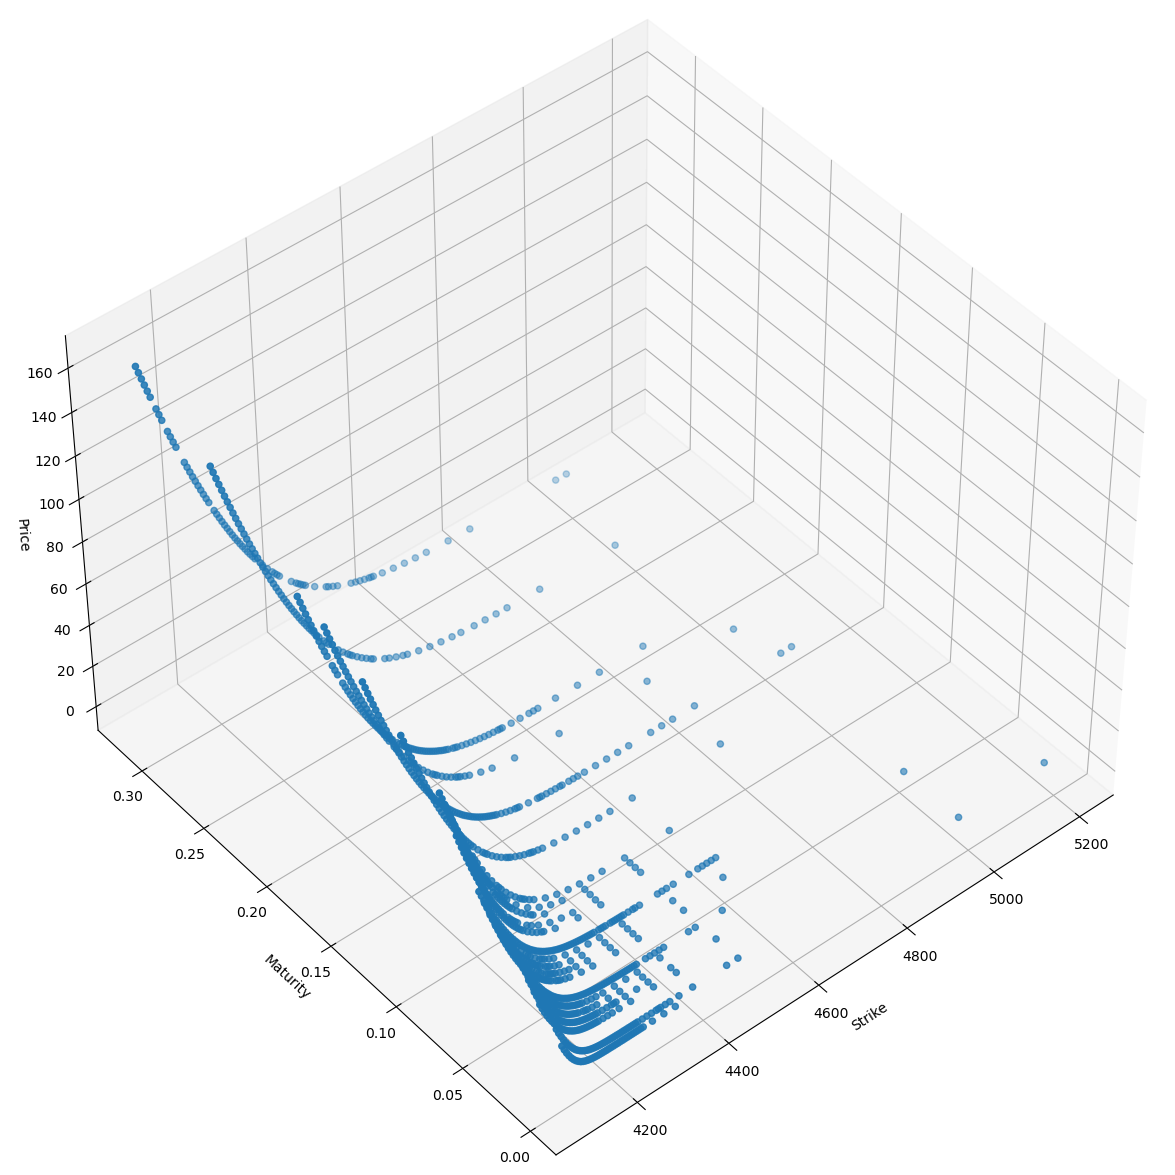

In [16]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

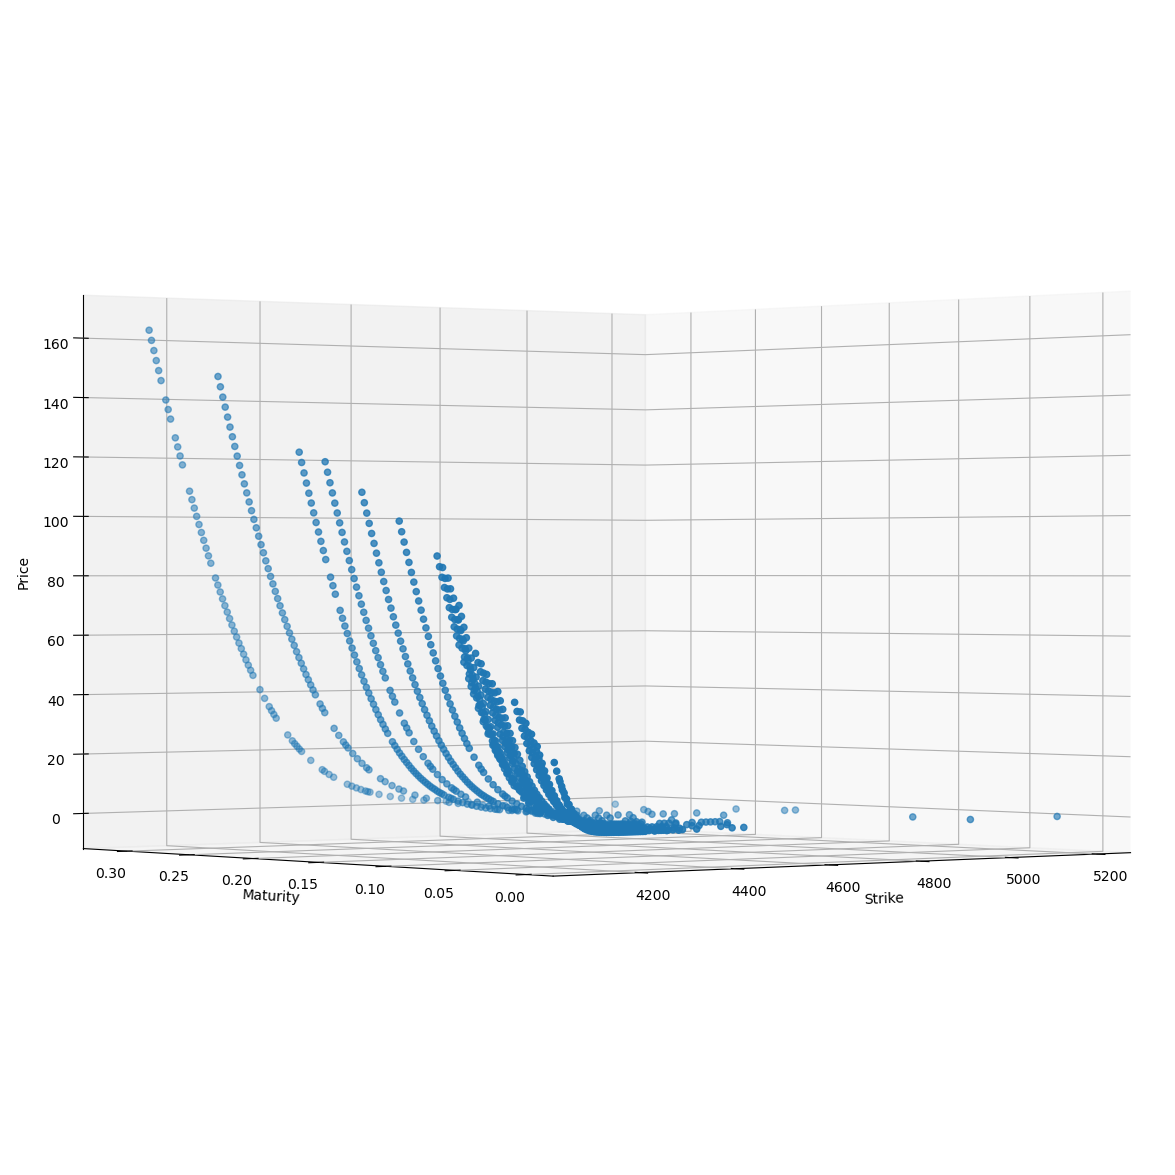

In [17]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=0, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

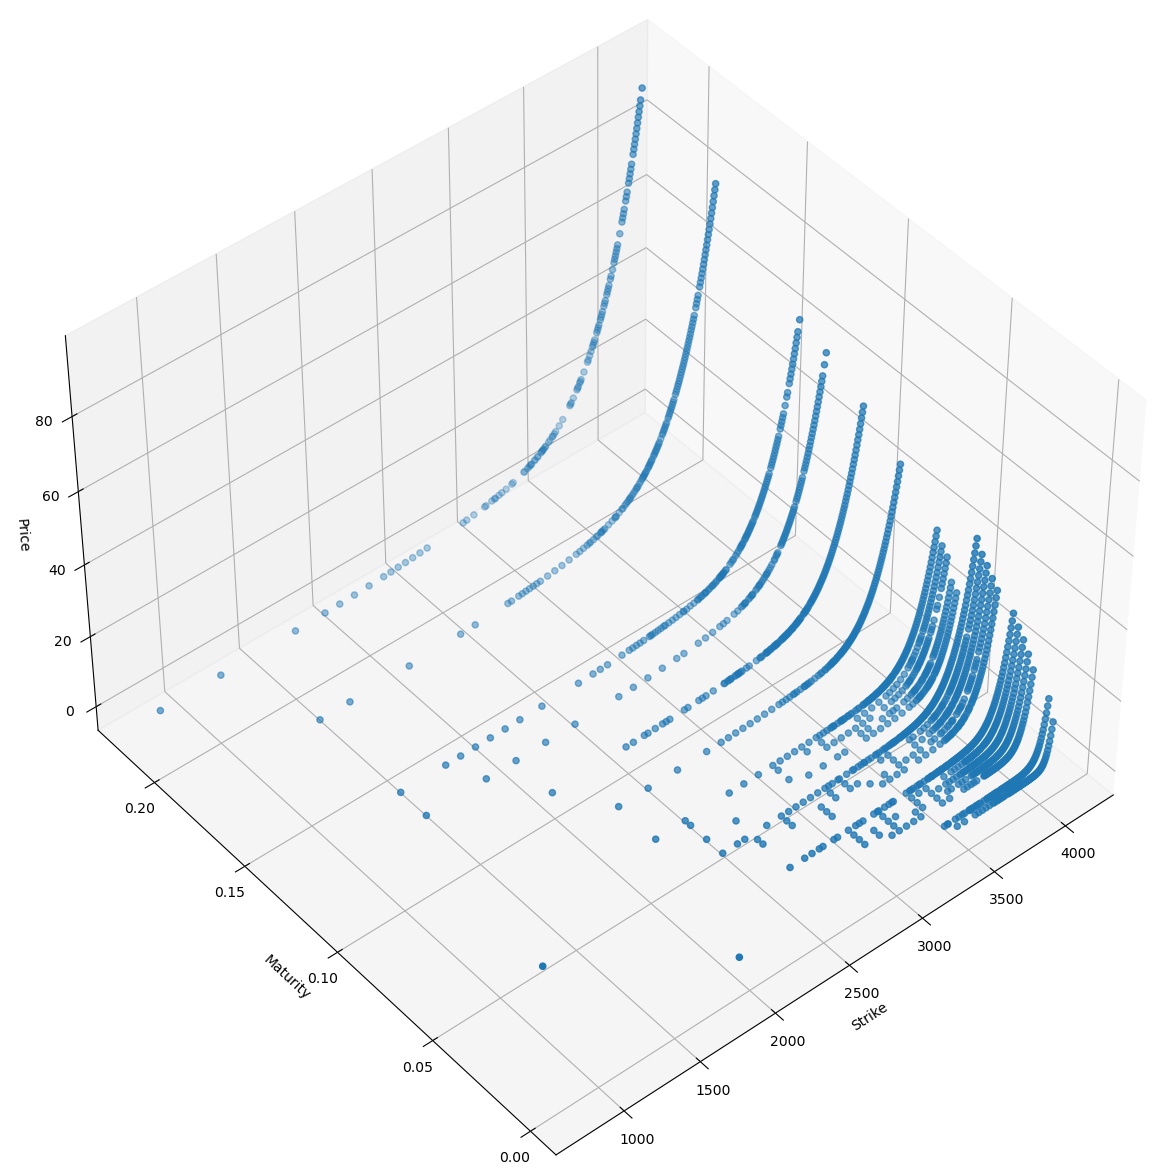

In [18]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(putPrices['Strike'], putPrices['Maturity'], putPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

### Building the marketprice matrix

In [19]:
strikes = pd.Series(callPrices['Strike'].unique()).sort_values().to_list()
maturities = pd.Series(callPrices['Maturity'].unique()).sort_values().to_list()
lenK = len(strikes)
lenT = len(maturities)

strike_m = []

#for i in strikes: 
for j in maturities: 
        #print(i, j)
        strike_m_temp = callPrices[(callPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m.append(strike_m_temp)
        
strikes = set(strike_m[0])
for i in range(1,len(strike_m)):
    strikes = strikes.intersection(set(strike_m[i]))

strikes = list(strikes)
strikes = sorted(strikes)
print(strikes)

marketPrices = np.zeros((len(strikes), len(maturities)))
w = np.zeros((len(strikes), len(maturities)))
for j in range(len(maturities)):
    for i in range(len(strikes)):
        #print(maturities[j])
        #print(strikes[i])
        #print(callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0])
        marketPrices[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0]
        w[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['w'][0]
        
marketPrices = marketPrices.T
w = w.T

[4105, 4110, 4120, 4125, 4130, 4140, 4150, 4170, 4190, 4200, 4210, 4220, 4225, 4230, 4250, 4275, 4300]


In [20]:
strikes_p = pd.Series(putPrices['Strike'].unique()).sort_values().to_list()
maturities_p = pd.Series(putPrices['Maturity'].unique()).sort_values().to_list()
lenK_p = len(strikes_p)
lenT_p = len(maturities_p)

strike_m_p = []

#for i in strikes: 
for j in maturities_p: 
        #print(i, j)
        strike_m_temp_p = putPrices[(putPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m_p.append(strike_m_temp_p)
        
strikes_p = set(strike_m_p[0])
for i in range(1,len(strike_m_p)):
    strikes_p = strikes_p.intersection(set(strike_m_p[i]))

strikes_p = list(strikes_p)
strikes_p = sorted(strikes_p)
#print(strikes_p)
#print(maturities_p)
marketPrices_p = np.zeros((len(strikes_p), len(maturities_p)))
w_p = np.zeros((len(strikes_p), len(maturities_p)))
for j in range(len(maturities_p)):
    for i in range(len(strikes_p)):
        #print(maturities_p[j])
        #print(strikes_p[i])
        #print(putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0])
        marketPrices_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0]
        w_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['w'][0]
        
marketPrices_p = marketPrices_p.T
w_p = w_p.T

# 1. Heston and VGSA parameters via calibration 

In [21]:
#Generating Option Price Surface Under A model from the list         
def generic_CF(u, params, T, model):
    
    if (model == 'GBM'):
        
        sig = params[0];
        mu = np.log(S0) + (r-q-sig**2/2)*T;
        a = sig*np.sqrt(T);
        phi = np.exp(1j*mu*u-(a*u)**2/2);
        
    elif(model == 'Heston'):
        
        kappa  = params[0];
        theta  = params[1];
        sigma  = params[2];
        rho    = params[3];
        v0     = params[4];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);
        
        pow1 = 2*kappa*theta/(sigma**2);

        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0); # manque un q ici en fait (dans le python file)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2));
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp);
        log_phi = numer1 - log_denum1 - tmp2;
        phi = np.exp(log_phi);

    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T;
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T);
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T;
            phi = cmath.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));
            
    elif (model == 'VGSA'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];
        kappa  = params[3]; 
        eta    = params[4];
        lbda   = params[5];
        
        #cf if mu = 0 ce qu'on fait
        #if (nu == 0):
        psi_VG_i = - np.log(1-theta*nu-sigma**2*nu*0.5)/nu
        psi_VG_u = - np.log(1-1j*u*theta*nu+sigma**2*nu*u**2*0.5)/nu
        
        tp = 1j*u * (np.log(S0) + (r-q)*T)
        
        def A(v):
            ga = np.sqrt(kappa**2 - 2*lbda**2*1j*v)
            A_t_u = np.exp(kappa**2*eta*T/(lbda**2))/((np.cosh(ga*T/2)+(kappa/ga)*np.sinh(ga*T/2))**(kappa*2*eta/(lbda**2)))
            return(A_t)
        def B(v):
            ga = np.sqrt(kappa**2 - 2*lbda**2*1j*v)
            B_t = 2*1j*v / (kappa+ ga/np.tanh(ga*T/2))
            return(B_t)
        
        A_t_u = np.exp(kappa**2*eta*T/(lbda**2))/((np.cosh(ga*T/2)+(kappa/ga)*np.sinh(ga*T/2))**(kappa*2*eta/(lbda**2)))
        B_t_u = 2*1j*u / (kappa+ ga/np.tanh(ga*T/2))
        
        phi_up = A(-1j*psi_VG_u)*np.exp(B(-j*psi_VG_u)/nu)
        phi_down = A(-1j*psi_VG_i)*np.exp(B(-j*psi_VG_i)/nu)
        print('fuck')
        phi = np.exp(tp)*phi_up/phi_down
        
    return phi

In [22]:
def genericFFT(params, T, model):
    
    # forming vector x and strikes km for m=1,...,N
    km = []
    xX = []
    
    # discount factor
    df = math.exp(-r*T)
    
    for j in range(N):
        
        nuJ=j*eta
        km.append(beta+j*lda)
        
        psi_nuJ = df*generic_CF(nuJ-(alpha+1)*1j, params, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        
        xX.append(cmath.exp(-1j*beta*nuJ)*psi_nuJ*wJ)
     
    yY = np.fft.fft(xX)
    
    cT_km = []    
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km.append(multiplier*np.real(yY[i]))
    
    return km, cT_km


In [23]:
# function for the search: 
def myRange(start, finish, increment):
    while (start <= finish):
        yield start
        start += increment
        
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

Here, for calibration, we will use Gradient-Based routines e.g. the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm.

# 1.1 Heston model:

#### Parameters
κ is the mean reversion speed, 
θ is the long run variance,
σ is the volatility of the volatility.

## 1.1.a Heston with equal weights on Call Prices

In [24]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

47.46841410710619
47.46841410029638


KeyboardInterrupt: 

In [ ]:
xopt

In [ ]:
params2 = xopt
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


In [ ]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices.T, label='Heston with BFGS (with equal weights)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.legend()

plt.show()

## 1.1.b Heston with weights inversely proportional to bid-ask spread on Call prices

In [ ]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, w)

num_iter = 1
[xopt_w, fopt_w, gopt_w, Bopt_w, func_calls_w, grad_calls_w, warnflg_w] = fmin_bfgs(
        mfc.eValue_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_w,
        maxiter=20,
        full_output=True, 
        retall=False)

In [ ]:
xopt_w

In [ ]:
params2 = xopt_w
lenT = len(maturities)
lenK = len(strikes)
modelPrices_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_w[i,j] = cT_km[0]

# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_w[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


In [ ]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_w.T, label='Heston with BFGS (with weights inversly proportional to bid-ask spread)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread)')

plt.legend()

plt.show()

## 1.1.c Heston with equal weights on Call & Put prices

In [ ]:
params = [ 2.34548424, 0.06375792, 0.59865706, -0.43626748, -0.95937438]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

r = 0.0485
q = 0.03310264838967327

model ='Heston'

def callbackF_full(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt_pc, fopt_pc, gopt_pc, Bopt_pc, func_calls_pc, grad_calls_pc, warnflg_pc] = fmin_bfgs(
        mfc.eValuefull,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full,
        maxiter=20,
        full_output=True, 
        retall=False)

In [ ]:
params2 = xopt_pc
lenT = len(maturities)
lenK = len(strikes)
modelPrices_pc = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_pc[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_pc[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with equal weights and calibration on Call and Put Prices)')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


In [ ]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_pc.T, label='Heston with BFGS (with equal weights and calibration on Call and put prices)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with equal weights and calibration on Call and put prices)')

plt.legend()

plt.show()

## 1.1.d Heston with weights inversely proportional to bid-ask spread on Call & Put prices

In [ ]:
params = [ 2.34548424, 0.06375792, 0.59865706, -0.43626748, -0.95937438]

# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF_full_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model, w, w_p)

num_iter = 1
[xopt_pc_w, fopt_pc_w, gopt_pc_w, Bopt_pc_w, func_calls_pc_w, grad_calls_pc_w, warnflg_pc_w] = fmin_bfgs(
        mfc.eValuefull_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full_w,
        maxiter=20,
        full_output=True, 
        retall=False)

In [ ]:
params2 = xopt_pc_w
lenT = len(maturities)
lenK = len(strikes)
modelPrices_pc_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_pc_w[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_pc_w[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread and calibration on Call and Put Prices)')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 

In [ ]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_pc_w.T, label='Heston with BFGS (with weights inversly proportional to bid-ask spread and calibration on Call and put prices)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread and calibration on Call and put prices)')

plt.legend()

plt.show()

# 1.2 VGSA model:

ΘVGSA = {σ, ν, θ, κ, η, λ}

## 1.2.a VGSA with equal weights on Call Prices

In [25]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model_v)

num_iter = 1
[xopt_v, fopt_v, gopt_v, Bopt_v, func_calls_v, grad_calls_v, warnflg_v] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

11.094009493443664
11.094040573565747
11.09399004224636
11.094083355067506
11.094009435252362
11.094009500372229
11.094009493420701
35.77346802982347
35.7734692900296
35.77346716539997
35.77346766150564
35.77346802343365
35.773468041137
35.77346802530013
50.599692358709206
50.599693090480805
50.59969214489359
50.599692169489956
50.59969235799966
50.59969235899224
50.599692358512726
51.61140352414158
51.61140353316297
51.611403523272685
51.61140352293013
51.611403524141245
51.61140352414165
51.61140352414153
51.5501969820057
51.550196508962635
51.55019694738898
51.55019679261976
51.55019698195886
51.55019698201174
51.55019698200134
24.906070262953392
24.90604383523351
24.906075846203596
24.90602137550146
24.906070280790285
24.906070260729656
24.90607026320455
4.364640128151006
4.364647046151742
4.36463833770402
4.364637311299423
4.364640132326639
4.364640127561174
4.364640128211321
 
i = 1
x_i = [0.02285316 0.03880567 0.0037478  2.38917371 1.89090448 0.84004647]
4.364640128151006
f_i = 

In [26]:
xopt_v

array([0.01663001, 0.03047202, 0.0047255 , 3.12228916, 0.69431883,
       1.15881395])

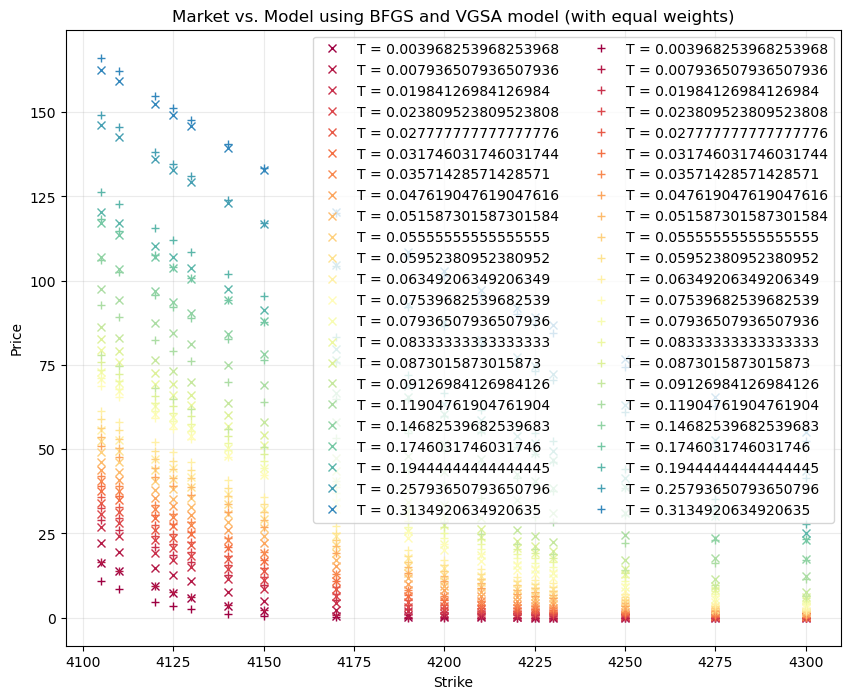

In [27]:
params2 = xopt_v
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model_v)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and VGSA model (with equal weights)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


## 1.2.b VGSA with weights inversely proportional to bid-ask spread on Call prices

In [ ]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model_v, w)

num_iter = 1
[xopt_v_w, fopt_v_w, gopt_v_w, Bopt_v_w, func_calls_v_w, grad_calls_v_w, warnflg_v_w] = fmin_bfgs(
        mfc.eValue_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_w,
        maxiter=20,
        full_output=True, 
        retall=False)

## 1.2.c VGSA with equal weights on Call & Put prices

In [ ]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_full(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model_v)

num_iter = 1
[xopt_v_pc, fopt_v_pc, gopt_v_pc, Bopt_v_pc, func_calls_v_pc, grad_calls_v_pc, warnflg_v_pc] = fmin_bfgs(
        mfc.eValuefull,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full,
        maxiter=20,
        full_output=True, 
        retall=False)

## 1.2.d VGSA with weights inversely proportional to bid-ask spread on Call & Put prices

In [ ]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_full_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model_v, w, w_p)

num_iter = 1
[xopt_v_w_pc, fopt_v_w_pc, gopt_v_w_pc, Bopt_v_w_pc, func_calls_v_w_pc, grad_calls_v_w_pc, warnflg_v_w_pc] = fmin_bfgs(
        mfc.eValuefull_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full_w,
        maxiter=20,
        full_output=True, 
        retall=False)

# 1.3 Results of calibration for the different algorihtms:
    

In [ ]:
df_param = pd.DataFrame({'Model':['Heston', 'Heston']*2,'Method':['BFGS with equal weights','BFGS with weights inversely proportional to bid-ask spread']*2, 'Prices':['Call']*2+['Call & Put']*2})

list_arg_heston = ['kappa','theta', 'sigma','rho', 'v0']
i=0
for para in list_arg_heston:
    df_param[para] = [xopt[i],xopt_w[i], xopt_pc[i], xopt_pc_w[i]]
    i+=1
    
df_param

In [ ]:
df_param_v = pd.DataFrame({'Model':['VGSA', 'VGSA']*2,'Method':['BFGS with equal weights','BFGS with weights inversely proportional to bid-ask spread']*2, 'Prices':['Call']*2+['Call & Put']*2})

list_arg_vgsa = ['sigma','nu','theta','kappa', 'eta', 'lambda']
i=0
for para in list_arg_heston:
    df_param_v[para] = [xopt_v[i],xopt_v_w[i],xopt_v_pc[i],xopt_v_w_pc[i]]
    i+=1
    
df_param_v

# 2. Local volatility surface

In [28]:
def vol_surface(params, strikes, maturities, modelPrices, model, title_):
    Prices = modelPrices.T
    params2 = params
    lenT = 3 * len(maturities)
    lenK = 3 * len(strikes)
    h_strikes = (strikes[-1] - strikes[0]) / lenK
    h_maturities = (maturities[-1] - maturities[0]) / lenT
    strikes_l = np.arange(strikes[0], strikes[-1] + h_strikes, h_strikes)
    maturities_l = np.arange(maturities[0], maturities[-1] + h_maturities, h_maturities)
    lenT = len(maturities_l)
    lenK = len(strikes_l)
    Prices = np.zeros((lenK, lenT))

    print('Computing the prices according to the model and the opt-parameters')
    for i in tqdm(range(lenK)):
        for j in range(lenT):
            T = maturities_l[j]
            K = strikes_l[i]
            [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
            Prices[i, j] = cT_km[0]

    sig_loc = np.zeros((lenK, lenT))
    print('Computing the local volatility surface')
    for i in tqdm(range(1, lenK - 1)):
        for j in range(1, lenT - 1):
            dC_dt = (Prices[i, j + 1] - Prices[i, j - 1]) / (maturities_l[j + 1] - maturities_l[j - 1])
            dC_dK = (Prices[i + 1, j] - Prices[i - 1, j]) / (strikes_l[i + 1] - strikes_l[i - 1])
            dC2_dK2 = (Prices[i + 1, j] - 2 * Prices[i, j] + Prices[i - 1, j]) / ((strikes_l[i + 1] - strikes_l[i]) * (strikes_l[i] - strikes_l[i - 1]))
            sig_loc[i, j] = np.sqrt(2 * (dC_dt + q * Prices[i, j] + (r - q) * strikes_l[i] * dC_dK) / (strikes_l[i] ** 2 * dC2_dK2))

    print(60 * '=')
    # create a meshgrid of the maturities and strikes
    maturities_, strikes_ = np.meshgrid(maturities_l[1:-1], strikes_l[1:-1])

    sig_loc_ = sig_loc[1:-1, 1:-1]
    print(np.shape(maturities_))
    print(np.shape(sig_loc_))

    # show plot
    fig = plt.figure(figsize=[15, 15])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(strikes_, maturities_, sig_loc_, cmap='rainbow')#cm.coolwarm, vmin=-1, vmax=1)
    #ax.scatter(strikes_, maturities_, sig_loc_, label='Local Volatility Surface')
    #ax.plot_wireframe(strikes_, maturities_, sig_loc_, label='Local Volatility Surface',cmap=cm.coolwarm)
    ax.view_init(elev=22, azim=160)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Local Volatility')
    ax.set_title(title_)

    plt.show()


''' As for the models, the results seem slightly better using with weights inversely proportional to bid-ask spread instead of equal weights, we will plot the local volatility surfaces for both VGSA and Heston model using the parameters obtained with with weights inversely proportional to bid-ask spread.'''

## 2.1 Local Volatility Surface for Heston model

In [ ]:
params_ = xopt_pc
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

In [ ]:
params_ = xopt_pc_w
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

## 2.2 Local Volatility Surface for VGSA model

Computing the prices according to the model and the opt-parameters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [01:08<00:00,  1.28s/it]


Computing the local volatility surface


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1508.07it/s]


(51, 68)
(51, 68)


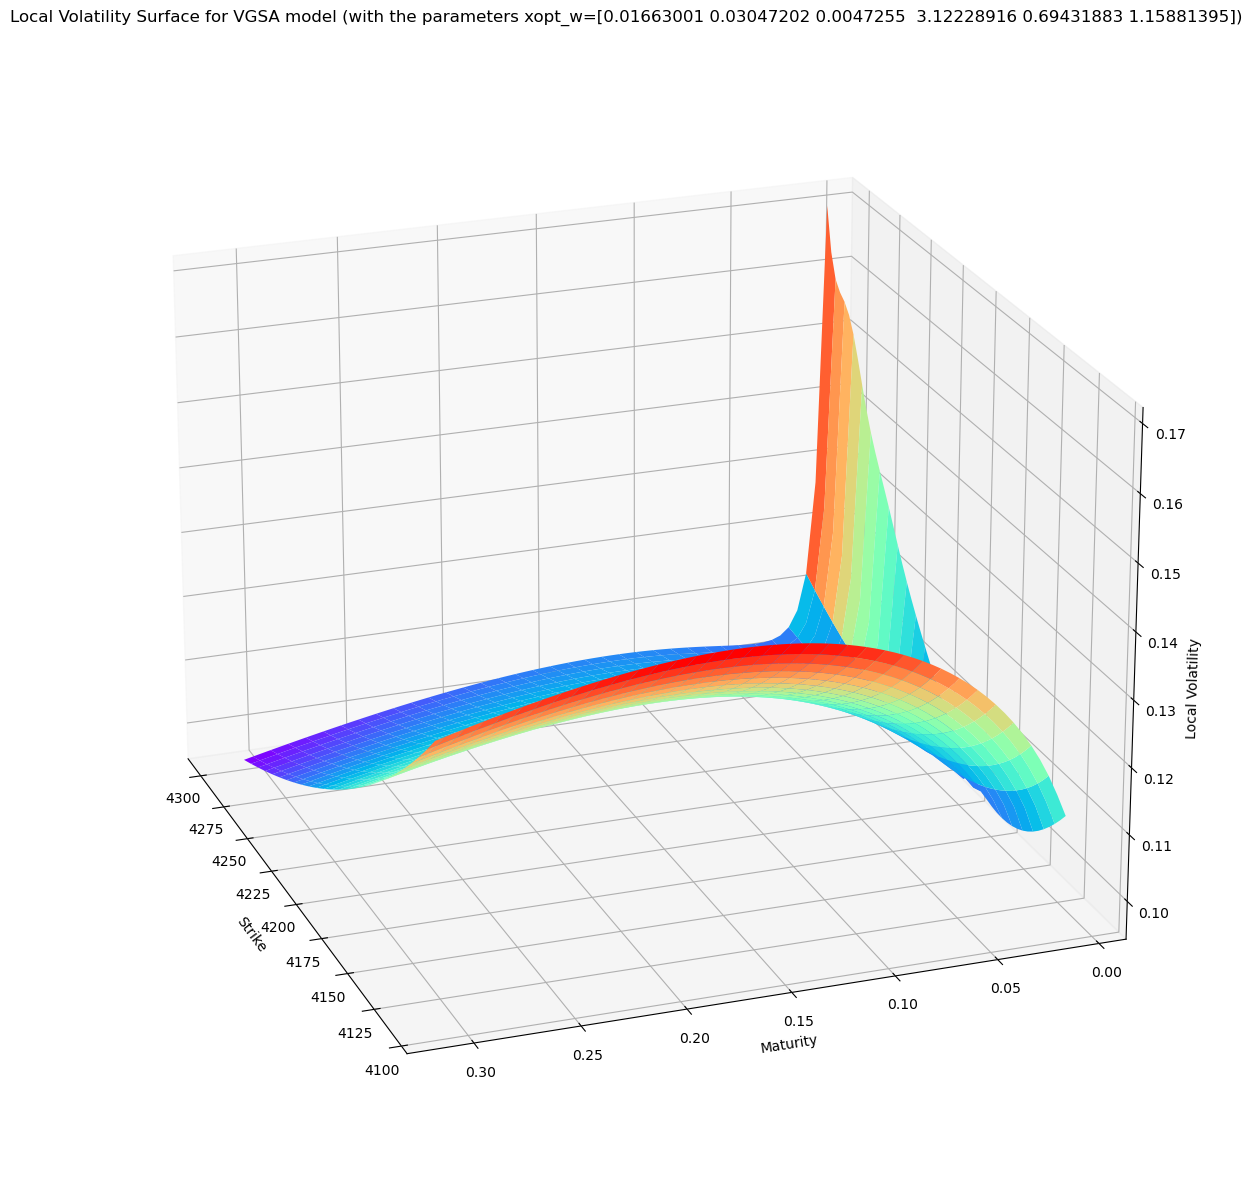

In [30]:
params_ = xopt_v
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

In [ ]:
params_ = xopt_v_w_pc
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

# 3. Findings/Observations

The Heston model assumes a constant correlation between the underlying asset and volatility, while the VGSA model allows for a varying correlation. This results in differences in the local volatility surface between the two models.The VGSA model is more flexible than the Heston model in terms of fitting market data. It can capture different shapes and behaviors of the implied volatility surface more accurately. We can see the surface for VGSA is indeed slightly more complex as can be seen for low maturity near the spot price. 

We can see the surfaces obtained for the 2 models the convexity of the surface are different. The slightly concave form of the surface at higher maturity for Heston is an element that makes this model more robust in a certain way here whereas VSGA is less optimist at longer term than Heston according its local vol surface.
Moreover, the VGSA model may have produced a smoother local volatility surface compared to the Heston model, which can exhibit more volatility and fluctuations.


Additionnal Notes : 

Here high local vol values at very low maturity for call options indicate that investors perceive a high probability of significant SP500 stock price movements in the very near future, which translates into high implied volatility for these options. This may be due to impending events such as major corporate announcements, quarterly earnings, macroeconomic events, which are happening in the beginning of the year or other events. 